In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

/Users/hyunsuk/.pyenv/versions/3.9.1/envs/ds/lib/python3.9/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


<div class="alert alert-success">
    <h3>1-1. Data (SQL)</h3>
</div>

In [2]:
connection = psycopg2.connect(host='localhost', dbname='coin', user='hyunsuk', password='fun309', port=5432)
cursor = connection.cursor()

sql = """
    SELECT *
    FROM candles
    WHERE datetime >= '2021-12-01 00:00:00'
"""
cursor.execute(sql)
df = pd.DataFrame(cursor.fetchall(), columns = ['market', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'value'])
df.set_index('datetime', inplace=True)
df.sort_index(ascending=True)
df.to_csv('data.csv')

<div class="alert alert-success">
    <h3>1-2. Data (File)</h3>
</div>

In [2]:
df = pd.read_csv('./data.csv', header=0)
df.set_index('datetime', inplace=True)
df.sort_index(ascending=True, inplace=True)

<div class="alert alert-success">
    <h3>2. 기술적 지표 (Feature Engineering)</h3>
</div>

In [3]:
def get_stochastic_fast_k(close_price, low, high, n=5):
    fast_k = ((close_price - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return fast_k

# Slow %K = Fast %K의 m기간 이동평균(SMA)
def get_stochastic_slow_k(fast_k, n=3):
    slow_k = fast_k.rolling(n).mean()
    return slow_k

# Slow %D = Slow %K의 t기간 이동평균(SMA)
def get_stochastic_slow_d(slow_k, n=3):
    slow_d = slow_k.rolling(n).mean()
    return slow_d

def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

def get_rsi(price, period=14):
    delta = price.diff()
    gains, declines = delta.copy(), delta.copy()
    gains[gains < 0] = 0
    declines[declines > 0] = 0
    
    _gain = gains.ewm(com=(period-1), min_periods=period).mean()
    _loss = declines.abs().ewm(com=(period-1), min_periods=period).mean()
    RS = _gain / _loss
    
    return pd.Series(100 - (100/(1+RS)), name = 'RSI')


## MA: 이동평균선
df['MA5'] = df['close'].rolling(window=5).mean()
df['MA20'] = df['close'].rolling(window=20).mean()
df['MA60'] = df['close'].rolling(window=60).mean()
df['MA120'] = df['close'].rolling(window=120).mean()
df['MA200'] = df['close'].rolling(window=200).mean()


## 볼린저 밴드
df['stddev'] = df['close'].rolling(window=20).std() # 20일 이동표준편차
df['upper'] = df['MA20'] + 2*df['stddev'] # 상단밴드
df['lower'] = df['MA20'] - 2*df['stddev'] # 하단밴드
df['upper-lower'] = df['upper']-df['lower']
df['upper-close'] = df['upper']-df['close']
df['close-lower'] = df['close']-df['lower']


df['MA20-MA5'] = df['MA20'] - df['MA5']
df['MA60-MA20'] = df['MA60'] - df['MA20']
df['MA120-MA60'] = df['MA120'] - df['MA60']
df['MA200-MA120'] = df['MA200'] - df['MA120']


#OBV 계산
OBV = []
OBV.append(0)

for i in range(1, len(df.close)):
    if df.close[i] > df.close[i-1]:
        OBV.append(OBV[-1]+df.volume[i])
    elif df.close[i] < df.close[i-1]:
        OBV.append(OBV[-1]-df.volume[i])
    else:
        OBV.append(OBV[-1])

df['OBV']=OBV
df['OBV_EMA']=df['OBV'].ewm(com=20).mean()
df['OBV-EMA']=df['OBV']-df['OBV_EMA']
        
            
## VA: 평균 거래량 (120일기준)
# df['VA5'] = df['volume'].rolling(window=5).mean()
# df['VA20'] = df['volume'].rolling(window=20).mean()
# df['VA60'] = df['volume'].rolling(window=60).mean()
# df['VA120'] = df['volume'].rolling(window=120).mean()
# df['VA120'] = df['volume'].rolling(window=120).mean()
# df['V/VA120'] = df['volume']/df['VA120']


## VALUE: 평균 거래금액 (120일기준)
# df['VAL5'] = df['value'].rolling(window=5).mean()
# df['VAL20'] = df['value'].rolling(window=20).mean()
# df['VAL60'] = df['value'].rolling(window=60).mean()
# df['VAL120'] = df['value'].rolling(window=120).mean()
# df['VAL200'] = df['value'].rolling(window=200).mean()

df['VAL5'] = df['value'].ewm(com=5).mean()
df['VAL20'] = df['value'].ewm(com=20).mean()
df['VAL60'] = df['value'].ewm(com=60).mean()
df['VAL120'] = df['value'].ewm(com=120).mean()
df['VAL200'] = df['value'].ewm(com=200).mean()


# MACD
macd_short, macd_long, macd_signal=12,26,9 #기본값
df["MACD_short"]=df['close'].ewm(span=macd_short).mean()
df["MACD_long"]=df['close'].ewm(span=macd_long).mean()
df["MACD"]=df.apply(lambda x: (x["MACD_short"]-x["MACD_long"]), axis=1)
df["MACD_signal"]=df["MACD"].ewm(span=macd_signal).mean()  
df["MACD_oscillator"]=df.apply(lambda x:(x["MACD"]-x["MACD_signal"]), axis=1)
df["MACD_sign"]=df.apply(lambda x: ("매수" if x["MACD"]>x["MACD_signal"] else "매도"), axis=1)


# fast_k, slow_k, slow_d를 획득
df['fast_k5'] = get_stochastic_fast_k(df['close'], df['low'], df['high'], 5)
df['slow_k3'] = get_stochastic_slow_k(df['fast_k5'], 3)
df['slow_d3'] = get_stochastic_slow_d(df['slow_k3'], 3)

df['fast_k10'] = get_stochastic_fast_k(df['close'], df['low'], df['high'], 10)
df['slow_k6'] = get_stochastic_slow_k(df['fast_k10'], 6)
df['slow_d6'] = get_stochastic_slow_d(df['slow_k6'], 6)

df['fast_k20'] = get_stochastic_fast_k(df['close'], df['low'], df['high'], 20)
df['slow_k12'] = get_stochastic_slow_k(df['fast_k20'], 12)
df['slow_d12'] = get_stochastic_slow_d(df['slow_k12'], 12)


# RSI
df['rsi'] = get_rsi(df['close'])

In [4]:
df.columns

Index(['market', 'open', 'high', 'low', 'close', 'volume', 'value', 'MA5',
       'MA20', 'MA60', 'MA120', 'MA200', 'stddev', 'upper', 'lower',
       'upper-lower', 'upper-close', 'close-lower', 'MA20-MA5', 'MA60-MA20',
       'MA120-MA60', 'MA200-MA120', 'OBV', 'OBV_EMA', 'OBV-EMA', 'VAL5',
       'VAL20', 'VAL60', 'VAL120', 'VAL200', 'MACD_short', 'MACD_long', 'MACD',
       'MACD_signal', 'MACD_oscillator', 'MACD_sign', 'fast_k5', 'slow_k3',
       'slow_d3', 'fast_k10', 'slow_k6', 'slow_d6', 'fast_k20', 'slow_k12',
       'slow_d12', 'rsi'],
      dtype='object')

<div class="alert alert-success">
    <h3>3-1. Independent Variable 설정</h3>
</div>

In [6]:
#t-1의 값을 Feature로 사용하기 위함
features = [
    'close', 'open', 'high', 'low', 'volume', 'MA5', 'MA20', 'MA60', 'MA120', 'MA200',
    'MA200-MA120', 'MA120-MA60', 'MA60-MA20', 'MA20-MA5', 
    'OBV-EMA',
    'VAL5', 'VAL20', 'VAL60', 'VAL120', 'VAL200',
    'MACD', 'MACD_oscillator', 
    'MACD_signal', 'fast_k5', 'slow_k3', 'slow_d3', 'fast_k10', 'slow_k6', 'slow_d6', 
    'fast_k20', 'slow_k12', 'slow_d12', 'rsi', 'upper-close', 'close-lower', 'stddev', 'upper-lower'
]

for feature in features:
    df[feature+'-1']=df[feature].shift(1)
    

#사용 Feature
selected_features = [
#     'volume-1', 
    'OBV-EMA-1',
    'VAL5-1', 'VAL20-1', 'VAL60-1', 'VAL120-1', 'VAL200-1',
    'MA20-MA5-1', 'MA60-MA20-1', 'MA120-MA60-1', 'MA200-MA120-1',
    'MACD-1', 'MACD_oscillator-1', 'MACD_signal-1', 'slow_k3-1', 'slow_d3-1', 'slow_k6-1', 'slow_d6-1', 
    'slow_k12-1', 'slow_d12-1', 'rsi-1', 'stddev-1', 'upper-lower-1', 'upper-close-1', 'close-lower-1'
]

X = df[selected_features].copy()
X.dropna(inplace=True)

In [7]:
print(X.index.strftime('%Y-%m-%d %H:%M:%S')[0])

2021-12-01 03:20:00


In [8]:
X.columns

Index(['OBV-EMA-1', 'VAL5-1', 'VAL20-1', 'VAL60-1', 'VAL120-1', 'VAL200-1',
       'MA20-MA5-1', 'MA60-MA20-1', 'MA120-MA60-1', 'MA200-MA120-1', 'MACD-1',
       'MACD_oscillator-1', 'MACD_signal-1', 'slow_k3-1', 'slow_d3-1',
       'slow_k6-1', 'slow_d6-1', 'slow_k12-1', 'slow_d12-1', 'rsi-1',
       'stddev-1', 'upper-lower-1', 'upper-close-1', 'close-lower-1'],
      dtype='object')

<div class="alert alert-success">
    <h3>3-2. Dependent Variable 설정</h3>
</div>

In [9]:
target_th = 0.02 # target earning rate per trade
fee = 0.0005 # trade fee
max_window = 120 # minutes

In [10]:
# Option 1 - Hit the target in window
y1 = df[["close"]].copy()
y1["close_t+20"] = y1["close"].shift(-20)
y1["close_t+60"] = y1["close"].shift(-60)
y1["close_t+120"] = y1["close"].shift(-120)

y1['earn+20'] = ((1 + target_th) * y1['close'] < y1['close_t+20']).astype(int)
y1['earn+60'] = ((1 + target_th) * y1['close'] < y1['close_t+60']).astype(int)
y1['earn+120'] = ((1 + target_th) * y1['close'] < y1['close_t+120']).astype(int)

y1["target"] = y1["earn+120"]
y1.dropna(inplace=True)

In [11]:
# Option2 - Hit the target in max_window (=120)
y2 = df[["close"]].copy()
y2.sort_index(inplace=True, ascending=False)
y2["max_in_wind"] = y2.rolling(max_window, closed="left").max()
y2["max_earn_in_wind"] = y2["max_in_wind"] / y2["close"] - 1
y2["target"] = (y2["max_earn_in_wind"] >= target_th).astype(int)
y2.sort_index(inplace=True)
y2["close_t+{}".format(max_window)] = y2["close"].shift(-max_window)

# target 수익률을 넘어서는 시간 추가
def idxmax(s, w):
    i = 0
    while i + w < len(s):
        yield(s.iloc[i:i+w].idxmax())
        i += 1

y2['idxmax'] = pd.Series(idxmax(y2['close'], max_window), y2.index[:-max_window])
y2.dropna(inplace=True)

In [12]:
# Option3 - Multi Classification 
y3 = df[["close"]].copy()

class_unit = 10 #minutes
for t in range(class_unit, max_window + class_unit, class_unit):
    y3["close_t+{}".format(t)] = y3["close"].shift(-t)
    y3["earn+{}".format(t)] = ((y3["close_t+{}".format(t)] / y3["close"] - 1) > target_th).astype(int)

selected_columns = ["earn+{}".format(t) for t in range(class_unit, max_window+class_unit, class_unit)]
target = y3[selected_columns].values.argmax(axis=1) + 1
target[y3[selected_columns].values.sum(axis=1) == 0] = 0
y3["target"] = target
y3.dropna(inplace=True)


<div class="alert alert-success">
    <h3>4. Train Model</h3>
</div>

In [13]:
#t-1의 값을 Feature로 사용하기 위함
data1 = X.join(y1[['target']], how='inner')
data2 = X.join(y2[['target']], how='inner')
data3 = X.join(y3[['target']], how='inner')

<AxesSubplot:xlabel='datetime'>

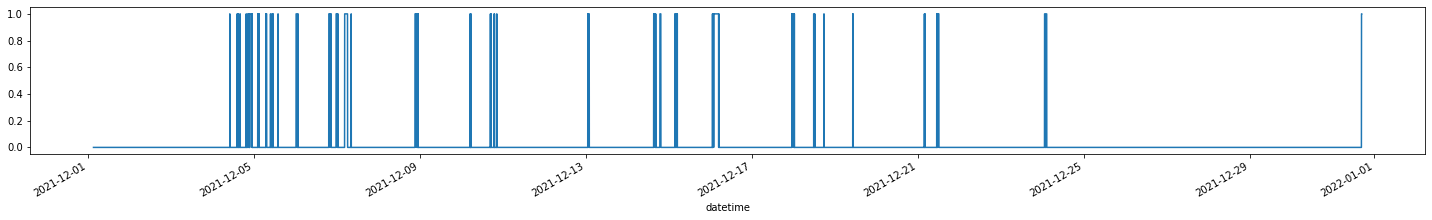

In [14]:
data1["target"].plot(figsize=(25, 3))

Total: 40312, Up: 2464


<AxesSubplot:xlabel='datetime'>

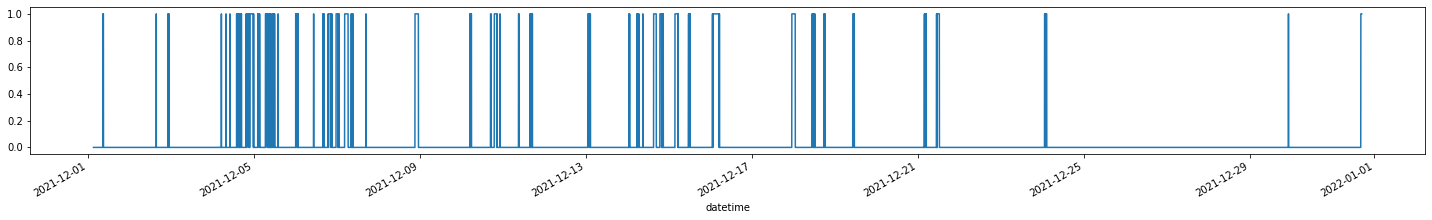

In [16]:
print('Total: {}, Up: {}'.format(len(data2), len(data2[data2['target']==1])))
data2["target"].plot(figsize=(25, 3))

<AxesSubplot:xlabel='datetime'>

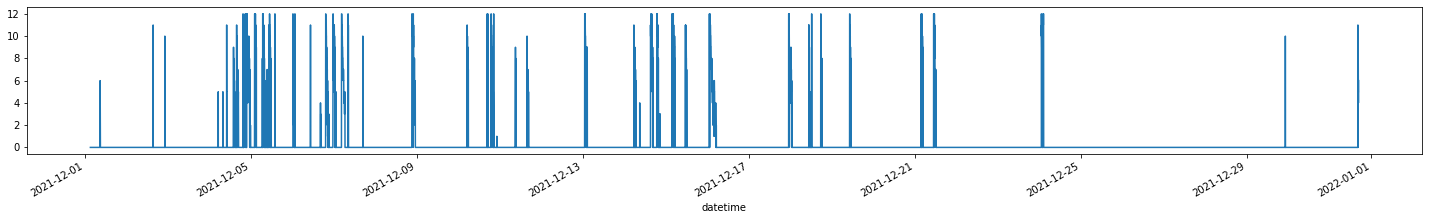

In [17]:
data3["target"].plot(figsize=(25, 3))

<div class="alert alert-warning">
    <h3>Option 1 (Fixed time)</h3>
</div>

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data1[selected_features], data1['target'], test_size=0.25, random_state=123456)

In [19]:
len(X_test.columns)

24

In [20]:
#시간으로 샘플링
start_date = "2021-11-01 00:00:00"
split_date = "2021-12-01 00:00:00"

data1_train = data1[start_date:split_date]
data1_train = data1_train.sample(frac=1)
data1_test = data1[split_date:]

<ipython-input-20-72abd9c9cfd4>:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  data1_train = data1[start_date:split_date]
<ipython-input-20-72abd9c9cfd4>:7: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  data1_test = data1[split_date:]


In [21]:
rf1 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf1.fit(X_train, y_train)

/Users/hyunsuk/.pyenv/versions/3.9.1/envs/ds/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(oob_score=True, random_state=123456)

In [23]:
predicted = rf1.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf1.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.988
Mean accuracy score: 0.991


In [24]:
loss1 = y2.loc[y_test[(y_test!=predicted) & (predicted==1)].index]
print('avg: {}'.format((loss1['close_t+120'] - loss1['close']).mean()))
print('min: {}'.format((loss1['close_t+120'] - loss1['close']).min()))
print('max: {}'.format((loss1['close_t+120'] - loss1['close']).max()))

avg: 89750.0
min: 85000.0
max: 94000.0


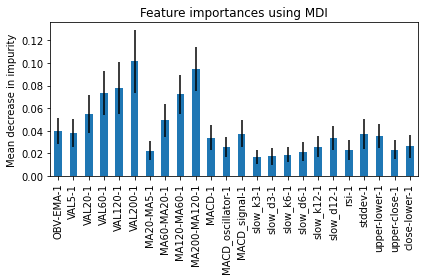

In [25]:
import numpy as np

importances = rf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf1.estimators_], axis=0)

forest_importances = pd.Series(importances, index=selected_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<div class="alert alert-warning">
    <h3>Option 2 (Hit the target within window)</h3>
</div>

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data2[selected_features], data2['target'], test_size=0.25, random_state=123456)

In [27]:
rf2 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf2.fit(X_train, y_train)

/Users/hyunsuk/.pyenv/versions/3.9.1/envs/ds/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(oob_score=True, random_state=123456)

In [28]:
predicted = rf2.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf2.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.978
Mean accuracy score: 0.982


In [29]:
y2.head()

,close,max_in_wind,max_earn_in_wind,target,close_t+120,idxmax
datetime,,,,,,
2021-12-01 00:00:00,5850000.0,5890000.0,0.006838,0,5689000.0,2021-12-01 00:16:00
2021-12-01 00:01:00,5838000.0,5890000.0,0.008907,0,5679000.0,2021-12-01 00:16:00
2021-12-01 00:02:00,5834000.0,5890000.0,0.009599,0,5696000.0,2021-12-01 00:16:00
2021-12-01 00:03:00,5825000.0,5890000.0,0.011159,0,5690000.0,2021-12-01 00:16:00
2021-12-01 00:04:00,5830000.0,5890000.0,0.010292,0,5681000.0,2021-12-01 00:16:00


In [30]:
# 실패시 손실 계산
loss2 = y2.loc[y_test[(y_test!=predicted) & (predicted==1)].index]
print('avg: {}'.format((loss2['close_t+{}'.format(max_window)] - loss2['close']).mean()))
print('min: {}'.format((loss2['close_t+{}'.format(max_window)] - loss2['close']).min()))
print('max: {}'.format((loss2['close_t+{}'.format(max_window)] - loss2['close']).max()))

avg: 25111.11111111111
min: -82000.0
max: 98000.0


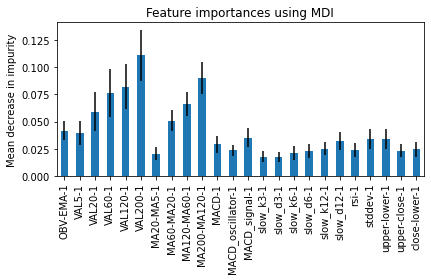

In [31]:
import numpy as np

importances = rf2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf2.estimators_], axis=0)

forest_importances = pd.Series(importances, index=selected_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<div class="alert alert-warning">
    <h3>Option 2-2 (Hit the target within window)</h3>
    <ul>
        <li>상승 시작하는 시점부터 이익이 나는 동안은 지표가 비슷하게 나타날 수 있음</li>
        <li>비슷한 데이터셋이 사용되면서 overfit 이슈가 생기지 않을까? </li>
        <li>2% 이상의 결과가 나오는 처음 시점만 찾아서 진행 </li>
    </ul>
</div>

In [32]:
data2['target-1']=data2.target.shift(1)

In [33]:
tmp = data2[(data2['target-1']!=data2['target']) & (data2['target']==1)]
data4 = tmp.append(data2[data2['target']==0])

In [34]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean

# define model
model = BalancedRandomForestClassifier(n_estimators=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(model, data4[selected_features], data4['target'], scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.743


In [35]:
X_train, X_test, y_train, y_test = train_test_split(data4[selected_features], data4['target'], test_size=0.25, random_state=123456)

rf4 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf4.fit(X_train, y_train)

/Users/hyunsuk/.pyenv/versions/3.9.1/envs/ds/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(oob_score=True, random_state=123456)

In [36]:
predicted = rf4.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf4.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.996
Mean accuracy score: 0.995


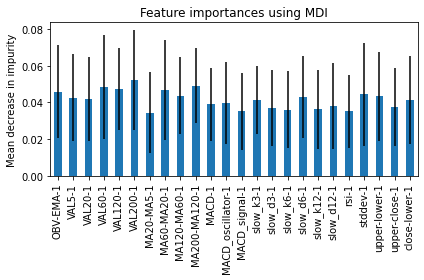

In [38]:
import numpy as np

importances = rf4.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf4.estimators_], axis=0)

forest_importances = pd.Series(importances, index=selected_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<div class="alert alert-danger">
    <h3>Target 1인 상황에서 MDD (Maximum Draw Down) 계산</h3>
</div>

In [39]:
y2.head()

,close,max_in_wind,max_earn_in_wind,target,close_t+120,idxmax
datetime,,,,,,
2021-12-01 00:00:00,5850000.0,5890000.0,0.006838,0,5689000.0,2021-12-01 00:16:00
2021-12-01 00:01:00,5838000.0,5890000.0,0.008907,0,5679000.0,2021-12-01 00:16:00
2021-12-01 00:02:00,5834000.0,5890000.0,0.009599,0,5696000.0,2021-12-01 00:16:00
2021-12-01 00:03:00,5825000.0,5890000.0,0.011159,0,5690000.0,2021-12-01 00:16:00
2021-12-01 00:04:00,5830000.0,5890000.0,0.010292,0,5681000.0,2021-12-01 00:16:00


In [40]:
# target hit한 window내, 최대 낙폭 index와 금액 계산
def mdd(y):
    for idx, row in y.iterrows():
        yield y[idx:row['idxmax']]['close'].idxmin(), y[idx:row['idxmax']]['close'].min() - row['close']

MDD = pd.DataFrame(mdd(y2), index=y2.index, columns=['idxmin', 'mdd'])

In [41]:
y2_MDD = y2.join(MDD, how='inner')

In [42]:
y2_MDD.head()

,close,max_in_wind,max_earn_in_wind,target,close_t+120,idxmax,idxmin,mdd
datetime,,,,,,,,
2021-12-01 00:00:00,5850000.0,5890000.0,0.006838,0,5689000.0,2021-12-01 00:16:00,2021-12-01 00:03:00,-25000.0
2021-12-01 00:01:00,5838000.0,5890000.0,0.008907,0,5679000.0,2021-12-01 00:16:00,2021-12-01 00:03:00,-13000.0
2021-12-01 00:02:00,5834000.0,5890000.0,0.009599,0,5696000.0,2021-12-01 00:16:00,2021-12-01 00:03:00,-9000.0
2021-12-01 00:03:00,5825000.0,5890000.0,0.011159,0,5690000.0,2021-12-01 00:16:00,2021-12-01 00:03:00,0.0
2021-12-01 00:04:00,5830000.0,5890000.0,0.010292,0,5681000.0,2021-12-01 00:16:00,2021-12-01 00:05:00,-3000.0


In [43]:
# 낙폭 정도 Normal Test
from scipy.stats import normaltest

stat, p = normaltest(y2_MDD['mdd'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=70714.779, p=0.000
Sample does not look Gaussian (reject H0)


Total size: 2491
Worst MDD: -607000.0


<AxesSubplot:xlabel='datetime'>

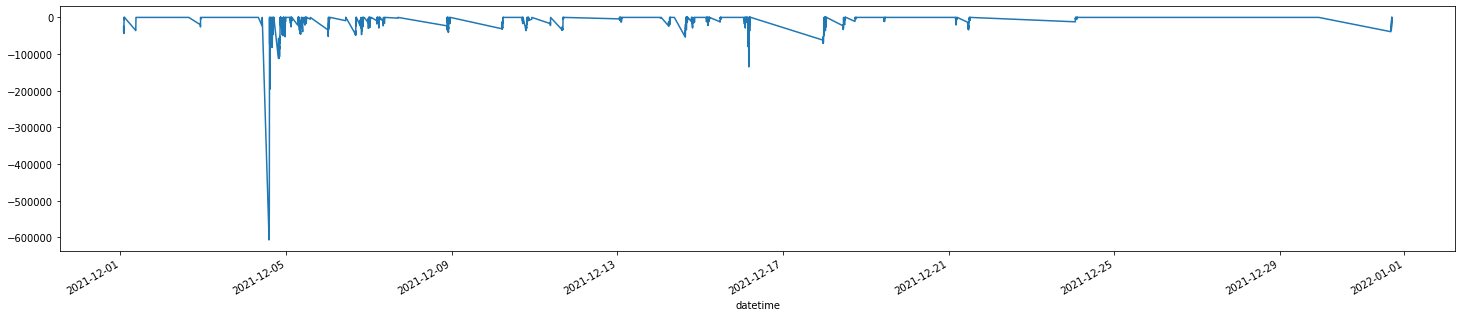

In [44]:
y2_target1 = y2_MDD[y2_MDD['target']==1]
print('Total size: {}'.format(len(y2_target1)))
print('Worst MDD: {}'.format(y2_target1['mdd'].min()))
y2_target1['mdd'].plot(figsize=(25,5))

In [45]:
y2_target1['mdd_ratio'] = y2_target1['mdd']/y2_target1['close']
loss_mean = y2_target1['mdd_ratio'].mean()
loss_std = y2_target1['mdd_ratio'].std()
print('손해 비율 (mean): {}'.format(y2_target1['mdd_ratio'].mean()))
print('손해 비율 (std): {}'.format(y2_target1['mdd_ratio'].std()))
print('손해 비율 (min): {}'.format(y2_target1['mdd_ratio'].min()))

손해 비율 (mean): -0.003373778869709378
손해 비율 (std): 0.008709296609168974
손해 비율 (min): -0.12120607028753994


<ipython-input-45-8de18fad554c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y2_target1['mdd_ratio'] = y2_target1['mdd']/y2_target1['close']


In [46]:
print(f'손절라인 outlier mean - 3*std: {loss_mean-3*loss_std}')

손절라인 outlier mean - 3*std: -0.0295016686972163


In [47]:
# target threshold보다 더 많은 손해가 중간에 발생한 경우 

print('Target 1 규모: {}'.format(len(y2_target1)))
print('최대낙폭 target_th 이상: {}'.format(len(y2_target1[y2_target1['mdd_ratio']<=-target_th])))

Target 1 규모: 2491
최대낙폭 target_th 이상: 46


<div class="alert alert-info">
    <h4>%% 최대 낙폭을 줄이는 알고리즘을 추가하여 손실을 줄이는 방식으로</h4>
</div>

<div class="alert alert-warning">
    <h3>모델 Save</h3>
</div>

In [38]:
import pickle
import joblib

In [143]:
joblib.dump(rf2, 'algo2.pkl') 

['algo2.pkl']

<div class="alert alert-warning">
    <h3>XGBoost 활용</h3>
</div>

In [180]:
import xgboost

xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

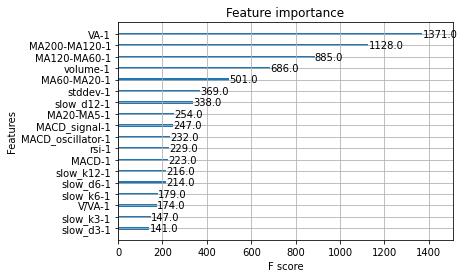

In [182]:
xgboost.plot_importance(xgb_model)

In [192]:
predicted = xgb_model.predict(X_test)
round_predicted = [round(value) for value in predicted]
accuracy = accuracy_score(y_test, round_predicted)
precision = precision_score(y_test, round_predicted, pos_label=1)
f1_sco = f1_score(y_test, round_predicted, pos_label=1)

                     
print(f'Mean accuracy score: {accuracy:.3}')
print(f'Precision socre: {precision:.3}')
print(f'f1 socre: {f1_sco:.3}')

Mean accuracy score: 0.956
Precision socre: 0.95
f1 socre: 0.241


In [204]:
# plot_confusion_matrix(xgb_model, y_test, round_predicted)
confusion_matrix(y_test, round_predicted)

array([[20380,     8],
       [  944,   151]])

In [186]:
# 실패시 손실 계산
xgb_loss2 = y2.loc[y_test[(y_test!=round_predicted) & (round_predicted==1)].index]
print('avg: {}'.format((xgb_loss2['close_t+{}'.format(max_window)] - xgb_loss2['close']).mean()))
print('min: {}'.format((xgb_loss2['close_t+{}'.format(max_window)] - xgb_loss2['close']).min()))
print('max: {}'.format((xgb_loss2['close_t+{}'.format(max_window)] - xgb_loss2['close']).max()))

avg: nan
min: nan
max: nan


### - Grid Search 너무 느림

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [55]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

In [ ]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()
